# Importing the required library

In [2]:
# rm -rf /kaggle/working/*

In [3]:
! pip install ultralytics

In [4]:
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO
from pathlib import Path
import os
import yaml
from PIL import Image
from collections import Counter

# Creating data.yaml file for training

In [5]:
# data.yaml content
data_yaml = """
path: /kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data

train: train/images
val: val/images
test: test/images

nc: 1
names: ['cheerios']
"""

# write the content into a file
with open('data.yaml', 'w') as file:
    file.write(data_yaml)

# Analyzing Dataset.


--- Analyzing train set ---
Total images: 431

--- Analyzing val set ---
Total images: 69

--- Analyzing test set ---
Total images: 164
Dataset classes: ['cheerios']


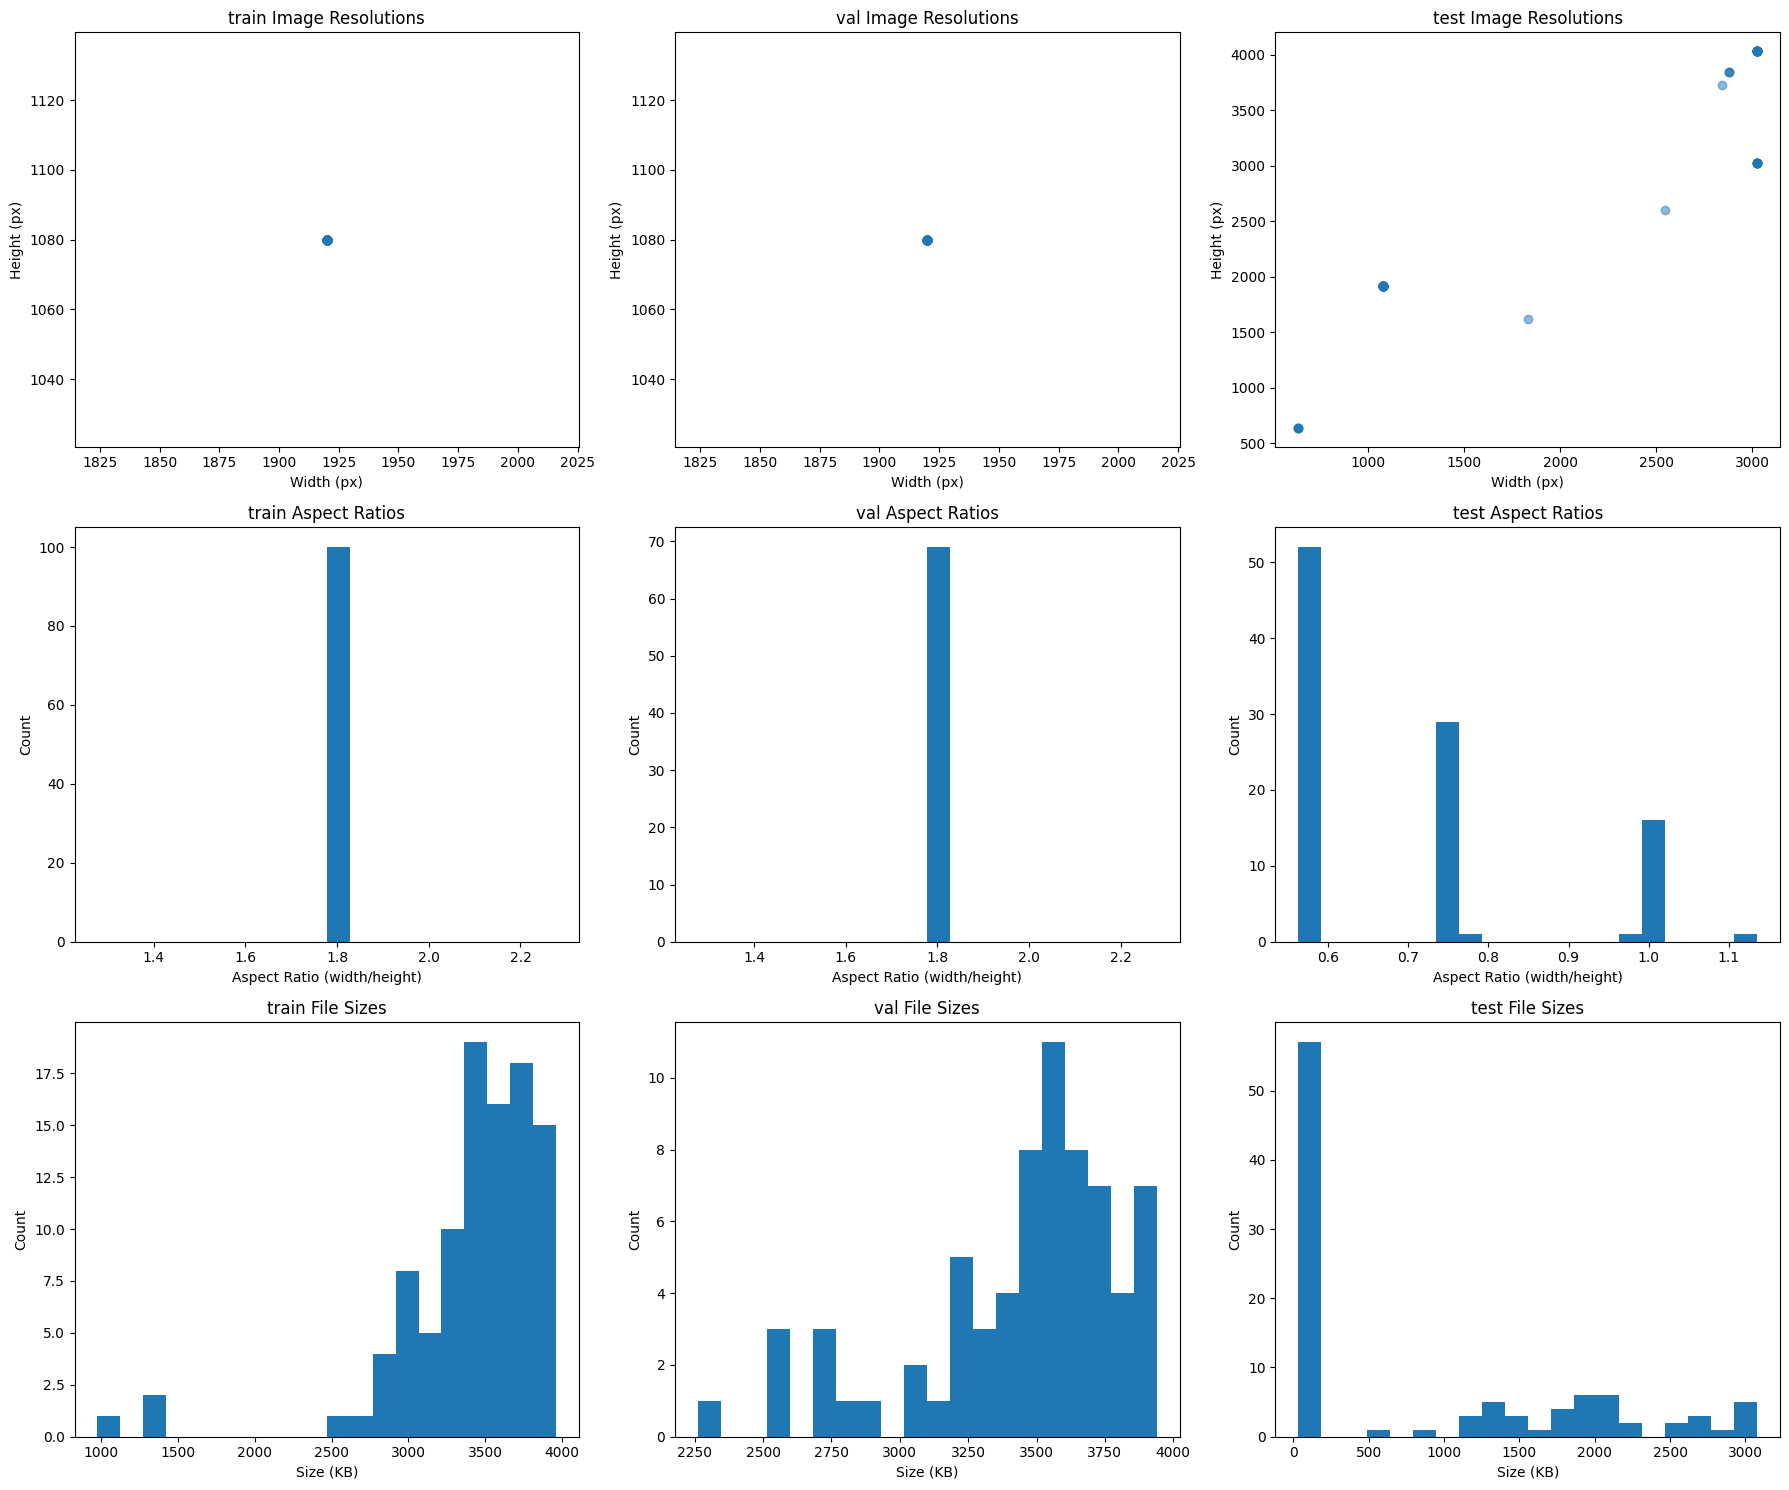


train format distribution:
  png: 100 images (100.0%)

val format distribution:
  png: 69 images (100.0%)

test format distribution:
  jpg: 100 images (100.0%)


In [6]:
def analyze_dataset(yaml_path):
    # Load the YAML file
    with open(yaml_path, 'r') as file:
        data = yaml.safe_load(file)
    
    base_path = data['path']
    
    # Function to analyze images in a specific split
    def analyze_split(split_name):
        if split_name not in data:
            return None
            
        split_path = os.path.join(base_path, data[split_name])
        if not os.path.exists(split_path):
            print(f"Path does not exist: {split_path}")
            return None
            
        print(f"\n--- Analyzing {split_name} set ---")
        
        # Get all image files
        image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
        images = []
        
        for root, _, files in os.walk(split_path):
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    images.append(os.path.join(root, file))
        
        if not images:
            print(f"No images found in {split_path}")
            return None
            
        print(f"Total images: {len(images)}")
        
        # Analyze a sample of images (to speed up the process)
        sample_size = min(len(images), 100)  # Analyze up to 100 images
        sampled_images = np.random.choice(images, sample_size, replace=False)
        
        widths, heights = [], []
        aspect_ratios = []
        formats = []
        file_sizes = []
        
        for img_path in sampled_images:
            try:
                # Get file size
                file_size = os.path.getsize(img_path) / 1024  # KB
                file_sizes.append(file_size)
                
                # Get image format
                img_format = os.path.splitext(img_path)[1].lower()[1:]
                formats.append(img_format)
                
                # Open the image to get dimensions
                with Image.open(img_path) as img:
                    width, height = img.size
                    widths.append(width)
                    heights.append(height)
                    aspect_ratios.append(width / height)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
        
        return {
            'total': len(images),
            'widths': widths,
            'heights': heights,
            'aspect_ratios': aspect_ratios,
            'formats': formats,
            'file_sizes': file_sizes
        }
    
    # Analyze each split
    results = {}
    for split in ['train', 'val', 'test']:
        results[split] = analyze_split(split)
    
    return results, data['names']

def visualize_results(results):
    plt.figure(figsize=(18, 15))
    
    split_count = 0
    for split_name, data in results.items():
        if data is None:
            continue
            
        split_count += 1
        
        # Image resolution scatter plot
        plt.subplot(3, 3, split_count)
        plt.scatter(data['widths'], data['heights'], alpha=0.5)
        plt.title(f'{split_name} Image Resolutions')
        plt.xlabel('Width (px)')
        plt.ylabel('Height (px)')
        
        # Aspect ratio histogram
        plt.subplot(3, 3, split_count + 3)
        plt.hist(data['aspect_ratios'], bins=20)
        plt.title(f'{split_name} Aspect Ratios')
        plt.xlabel('Aspect Ratio (width/height)')
        plt.ylabel('Count')
        
        # File size histogram
        plt.subplot(3, 3, split_count + 6)
        plt.hist(data['file_sizes'], bins=20)
        plt.title(f'{split_name} File Sizes')
        plt.xlabel('Size (KB)')
        plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # Print format statistics
    for split_name, data in results.items():
        if data is None:
            continue
        format_counter = Counter(data['formats'])
        print(f"\n{split_name} format distribution:")
        for fmt, count in format_counter.most_common():
            print(f"  {fmt}: {count} images ({count/len(data['formats'])*100:.1f}%)")

# Run the analysis
results, class_names = analyze_dataset('data.yaml')
print(f"Dataset classes: {class_names}")
visualize_results(results)

# Data Augmentation

In [7]:
import os
import yaml
import shutil
import cv2
import numpy as np
import albumentations as A
from glob import glob
from tqdm import tqdm

# Load the data.yaml
with open('data.yaml', 'r') as file:
    data_config = yaml.safe_load(file)

# Get paths
base_path = data_config['path']
train_path = os.path.join(base_path, data_config['train'])
train_images = glob(os.path.join(train_path, '*.jpg')) + glob(os.path.join(train_path, '*.png'))

# Create augmented directory in the writable /kaggle/working directory
aug_base_path = '/kaggle/working/data_augmented'
aug_train_path = os.path.join(aug_base_path, 'train/images')
aug_train_labels_path = os.path.join(aug_base_path, 'train/labels')
aug_val_path = os.path.join(aug_base_path, 'val/images')
aug_val_labels_path = os.path.join(aug_base_path, 'val/labels')
aug_test_path = os.path.join(aug_base_path, 'test/images')
aug_test_labels_path = os.path.join(aug_base_path, 'test/labels')

# Create directories
os.makedirs(aug_train_path, exist_ok=True)
os.makedirs(aug_train_labels_path, exist_ok=True)
os.makedirs(aug_val_path, exist_ok=True)
os.makedirs(aug_val_labels_path, exist_ok=True)
os.makedirs(aug_test_path, exist_ok=True)
os.makedirs(aug_test_labels_path, exist_ok=True)

# Define augmentation pipeline
transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussNoise(p=0.2),
    A.Blur(blur_limit=3, p=0.1),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Copy and augment training images
print("Augmenting training images...")
for img_path in tqdm(train_images):
    # Get image name and read image
    img_name = os.path.basename(img_path)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image {img_path}")
        continue
    
    # Get corresponding label path
    label_path = img_path.replace('images', 'labels').replace('.jpg', '.txt').replace('.png', '.txt')
    
    # Copy original image and label
    shutil.copy2(img_path, os.path.join(aug_train_path, img_name))
    if os.path.exists(label_path):
        shutil.copy2(label_path, os.path.join(aug_train_labels_path, os.path.basename(label_path)))
    else:
        print(f"Warning: Label not found for {img_path}")
        continue
        
    # Read label
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    # Parse YOLO format labels
    bboxes = []
    class_labels = []
    
    for line in lines:
        values = line.strip().split()
        class_id = int(values[0])
        x_center, y_center, width, height = map(float, values[1:5])
        bboxes.append([x_center, y_center, width, height])
        class_labels.append(class_id)
    
    # Apply augmentation
    if bboxes:  # Only augment if there are bounding boxes
        for i in range(3):  # Create 3 augmented versions
            augmented = transform(image=img, bboxes=bboxes, class_labels=class_labels)
            aug_img = augmented['image']
            aug_bboxes = augmented['bboxes']
            aug_labels = augmented['class_labels']
            
            # Save augmented image
            aug_img_name = f"aug_{i}_{img_name}"
            cv2.imwrite(os.path.join(aug_train_path, aug_img_name), aug_img)
            
            # Save augmented labels
            aug_label_name = aug_img_name.replace('.jpg', '.txt').replace('.png', '.txt')
            with open(os.path.join(aug_train_labels_path, aug_label_name), 'w') as f:
                for j in range(len(aug_bboxes)):
                    bbox = aug_bboxes[j]
                    label = aug_labels[j]
                    f.write(f"{label} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

# Copy validation and test data (no augmentation)
print("Copying validation data...")
val_images_dir = os.path.join(base_path, data_config['val'])
val_images = glob(os.path.join(val_images_dir, '*.jpg')) + glob(os.path.join(val_images_dir, '*.png'))
for img_path in tqdm(val_images):
    img_name = os.path.basename(img_path)
    label_path = img_path.replace('images', 'labels').replace('.jpg', '.txt').replace('.png', '.txt')
    
    shutil.copy2(img_path, os.path.join(aug_val_path, img_name))
    if os.path.exists(label_path):
        shutil.copy2(label_path, os.path.join(aug_val_labels_path, os.path.basename(label_path)))

print("Copying test data...")
test_images_dir = os.path.join(base_path, data_config['test'])
test_images = glob(os.path.join(test_images_dir, '*.jpg')) + glob(os.path.join(test_images_dir, '*.png'))
for img_path in tqdm(test_images):
    img_name = os.path.basename(img_path)
    shutil.copy2(img_path, os.path.join(aug_test_path, img_name))
    
    # Copy test labels if they exist (though they might not for test data)
    label_path = img_path.replace('images', 'labels').replace('.jpg', '.txt').replace('.png', '.txt')
    if os.path.exists(label_path):
        shutil.copy2(label_path, os.path.join(aug_test_labels_path, os.path.basename(label_path)))

# Create new data.yaml for augmented dataset
new_data_yaml = data_config.copy()
new_data_yaml['path'] = aug_base_path

with open('/kaggle/working/data_augmented.yaml', 'w') as file:
    yaml.dump(new_data_yaml, file)

print(f"Augmentation complete. New dataset config saved to /kaggle/working/data_augmented.yaml")

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Augmenting training images...


100%|██████████| 431/431 [04:01<00:00,  1.79it/s]


Copying validation data...


100%|██████████| 69/69 [00:00<00:00, 169.31it/s]


Copying test data...


100%|██████████| 164/164 [00:00<00:00, 550.79it/s]

Augmentation complete. New dataset config saved to /kaggle/working/data_augmented.yaml


# Training the yolov8 model

In [8]:
# using yolo v8 large
model = YOLO("yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:00<00:00, 154MB/s] 


In [9]:
model.train(
    data="/kaggle/working/data.yaml",  # Use the augmented dataset path
    seed=42,
    epochs=40,                
    batch=32,
    imgsz=640,
    patience=200,
    optimizer='Adam',
    lr0=0.0001,
    weight_decay=0.0001,
    cos_lr=True,
    # Augmentations
    # hsv_h=0.025, 
    # hsv_s=0.7,
    # hsv_v=0.4,
    # flipud=0.5,
    # fliplr=0.5,
    # translate=0.175,
    # scale=0.5,
    # erasing=0.35,
    # shear=0.02,
    # mixup=0.02,
    # Miscellaneous
    single_cls=True,
)

Ultralytics 8.3.101 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/data.yaml, epochs=40, time=None, patience=200, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=True, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

100%|██████████| 5.35M/5.35M [00:00<00:00, 66.6MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/train/labels... 431 images, 7 backgrounds, 0 corrupt: 100%|██████████| 431/431 [00:01<00:00, 370.41it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/val/labels... 69 images, 1 backgrounds, 0 corrupt: 100%|██████████| 69/69 [00:00<00:00, 276.64it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/val is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      7.06G     0.6443      9.098     0.9829         23        640: 100%|██████████| 14/14 [00:15<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


                   all         69         68      0.113      0.147     0.0697     0.0583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      7.45G     0.5197      1.102     0.9181         22        640: 100%|██████████| 14/14 [00:12<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]

                   all         69         68       0.84     0.0777      0.356      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      7.45G     0.5229     0.5395     0.9291         34        640: 100%|██████████| 14/14 [00:11<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]

                   all         69         68      0.929      0.897      0.952      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      7.45G     0.5086     0.4794     0.9321         27        640: 100%|██████████| 14/14 [00:11<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

                   all         69         68      0.926      0.956      0.976      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      7.45G     0.4637     0.4284     0.8884         31        640: 100%|██████████| 14/14 [00:12<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]

                   all         69         68      0.919          1      0.989      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      7.45G     0.4234     0.3835     0.8776         29        640: 100%|██████████| 14/14 [00:12<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

                   all         69         68      0.964      0.985       0.99      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      7.45G     0.4305     0.3701     0.8711         27        640: 100%|██████████| 14/14 [00:12<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         69         68      0.971      0.975       0.99      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      7.45G     0.4055     0.3399     0.8648         32        640: 100%|██████████| 14/14 [00:11<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         69         68      0.967      0.985      0.993      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      7.45G     0.3863     0.3136     0.8573         33        640: 100%|██████████| 14/14 [00:12<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         69         68      0.999      0.985      0.995      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      7.45G     0.3664     0.3041     0.8437         30        640: 100%|██████████| 14/14 [00:11<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         69         68      0.983      0.985      0.994      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      7.45G     0.3887     0.3107     0.8565         36        640: 100%|██████████| 14/14 [00:11<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.54it/s]

                   all         69         68      0.985      0.997      0.993      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      7.45G     0.3654     0.3007     0.8593         26        640: 100%|██████████| 14/14 [00:12<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         69         68      0.983          1      0.993      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      7.45G     0.3636     0.3001     0.8519         28        640: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

                   all         69         68      0.929          1      0.988       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      7.45G     0.3787     0.2996     0.8649         24        640: 100%|██████████| 14/14 [00:11<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.24it/s]

                   all         69         68      0.955      0.985      0.986      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      7.45G     0.3675      0.296     0.8604         25        640: 100%|██████████| 14/14 [00:12<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]

                   all         69         68      0.969          1       0.99      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      7.45G     0.3775     0.2946     0.8578         22        640: 100%|██████████| 14/14 [00:11<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.39it/s]

                   all         69         68       0.97          1      0.992      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      7.45G     0.3581     0.2845      0.856         27        640: 100%|██████████| 14/14 [00:12<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

                   all         69         68      0.953          1      0.993      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      7.45G     0.3576     0.2727     0.8605         22        640: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]

                   all         69         68      0.985          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      7.45G     0.3445       0.27      0.852         35        640: 100%|██████████| 14/14 [00:11<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.24it/s]

                   all         69         68      0.981          1      0.994      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      7.45G     0.3293     0.2597     0.8388         26        640: 100%|██████████| 14/14 [00:12<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

                   all         69         68      0.998          1      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      7.45G     0.3419     0.2644     0.8484         28        640: 100%|██████████| 14/14 [00:11<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         69         68      0.996          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      7.45G     0.3427     0.2589     0.8578         29        640: 100%|██████████| 14/14 [00:11<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.22it/s]

                   all         69         68       0.97          1      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      7.45G     0.3225     0.2523     0.8408         27        640: 100%|██████████| 14/14 [00:12<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.46it/s]

                   all         69         68      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      7.45G     0.3307     0.2586     0.8468         27        640: 100%|██████████| 14/14 [00:12<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

                   all         69         68      0.995          1      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      7.45G     0.3406     0.2602     0.8454         31        640: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]

                   all         69         68      0.994          1      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      7.45G     0.3032     0.2383     0.8429         33        640: 100%|██████████| 14/14 [00:12<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.20it/s]

                   all         69         68          1      0.994      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      7.45G     0.3241     0.2539     0.8482         19        640: 100%|██████████| 14/14 [00:12<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]

                   all         69         68          1      0.997      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      7.45G     0.3225     0.2511     0.8446         25        640: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         69         68          1      0.994      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      7.45G     0.3088     0.2459     0.8525         30        640: 100%|██████████| 14/14 [00:12<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         69         68      0.999      0.985      0.995      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      7.45G     0.3101      0.243      0.851         28        640: 100%|██████████| 14/14 [00:12<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         69         68      0.985      0.996      0.995      0.989


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      7.45G     0.2295       0.21     0.7757         15        640: 100%|██████████| 14/14 [00:19<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]

                   all         69         68      0.985          1      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      7.45G       0.22     0.1974     0.7683         14        640: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         69         68      0.994          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      7.45G     0.2259      0.197     0.7737         15        640: 100%|██████████| 14/14 [00:11<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         69         68      0.994          1      0.995      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      7.45G     0.2228     0.1839     0.7768         15        640: 100%|██████████| 14/14 [00:12<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

                   all         69         68      0.984          1      0.995      0.987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      7.45G     0.2005     0.1733     0.7883         14        640: 100%|██████████| 14/14 [00:11<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

                   all         69         68      0.983          1      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      7.45G     0.2074     0.1781     0.7745         15        640: 100%|██████████| 14/14 [00:11<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         69         68      0.984          1      0.994      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      7.45G     0.2192     0.1824     0.7719         15        640: 100%|██████████| 14/14 [00:11<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         69         68      0.986          1      0.994      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      7.45G     0.2062     0.1712      0.776         15        640: 100%|██████████| 14/14 [00:12<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.18it/s]

                   all         69         68      0.985      0.998      0.994      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      7.45G     0.2061     0.1722     0.7632         15        640: 100%|██████████| 14/14 [00:11<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.67it/s]

                   all         69         68      0.985      0.997      0.994      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      7.45G     0.2111     0.1805     0.7576         14        640: 100%|██████████| 14/14 [00:11<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]

                   all         69         68      0.985      0.997      0.994      0.989



40 epochs completed in 0.152 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.101 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]


                   all         69         68          1      0.994      0.995      0.993


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 3.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e215ffee230>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Visualizing training metrics and losses

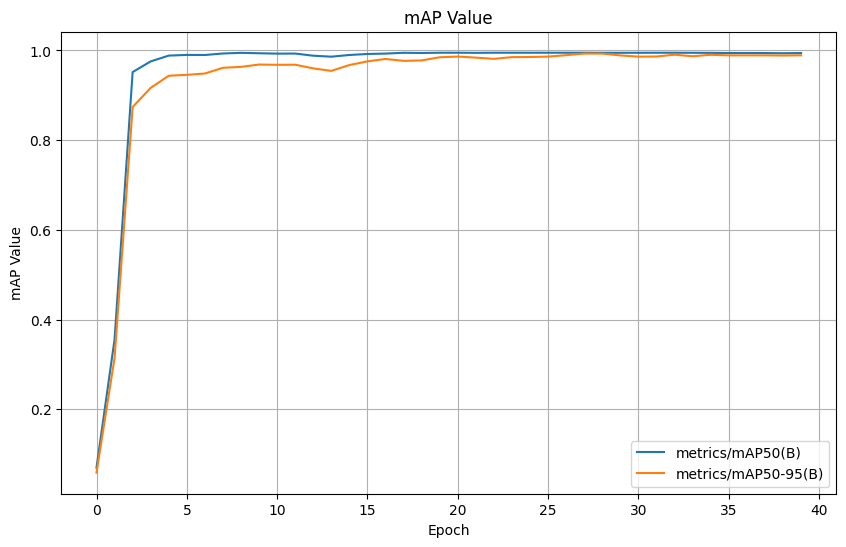

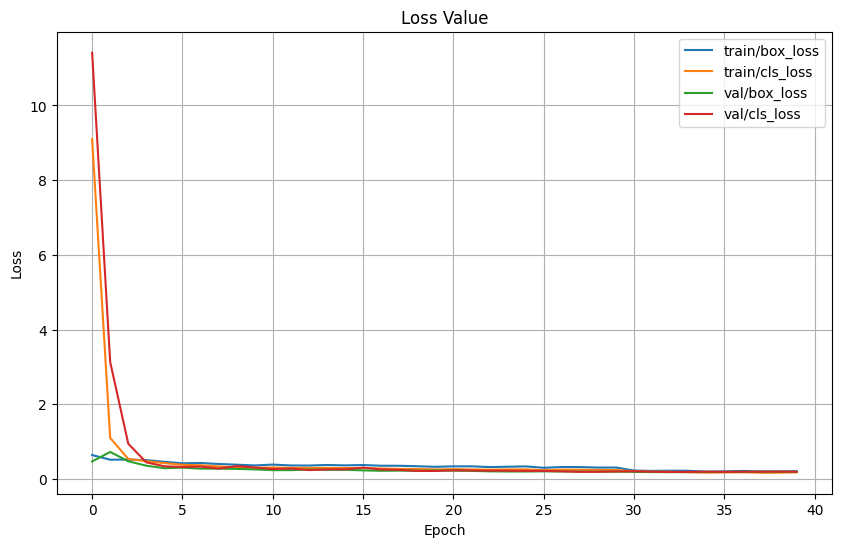

In [10]:
metrics_path = "/kaggle/working/runs/detect/train/results.csv"
metrics = pd.read_csv(metrics_path)

metrics[['metrics/mAP50(B)', 'metrics/mAP50-95(B)']].plot(figsize=(10, 6))
plt.title("mAP Value")
plt.xlabel("Epoch")
plt.ylabel("mAP Value")
plt.grid()
plt.show()


metrics[['train/box_loss', 'train/cls_loss', 'val/box_loss', 'val/cls_loss']].plot(figsize=(10, 6))
plt.title("Loss Value")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

# Testing the trained YOLOv8 model and saving predictions

In [11]:
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

test_images_path = "/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/test/images"
output_dir = "/kaggle/working/predictions/labels"

os.makedirs(output_dir, exist_ok=True)

for img_path in Path(test_images_path).glob("*"):
    if img_path.suffix.lower() not in ['.png', '.jpg', '.jpeg']:
        continue

    results = model.predict(img_path, conf=0.05)  

    output_txt = Path(output_dir) / f"{img_path.stem}.txt"

    with open(output_txt, "w") as f:
        for result in results:
            img_height, img_width = result.orig_shape
            for box in result.boxes.data:
                x1, y1, x2, y2, confidence, cls_id = box.tolist()

                x_center = ((x1 + x2) / 2) / img_width
                y_center = ((y1 + y2) / 2) / img_height
                width = (x2 - x1) / img_width
                height = (y2 - y1) / img_height

                f.write(f"0 {confidence:.6f} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

print(f"[notice] ✅ Tahminler kaydedildi: {output_dir}")


image 1/1 /kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/test/images/0106.jpg: 640x384 1 item, 39.2ms
Speed: 1.9ms preprocess, 39.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/test/images/IMG_3114.jpg: 640x640 1 item, 16.8ms
Speed: 1.5ms preprocess, 16.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/test/images/0273.jpg: 640x384 1 item, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/test/images/0255.jpg: 640x384 1 item, 10.6ms
Speed: 1.8ms preprocess, 10.6ms inference, 1.1ms 

# Convert the predictions into a csv file

In [12]:
def predictions_to_csv(
    preds_folder: str = "/kaggle/working/predictions/labels", 
    output_csv: str = "/kaggle/working/submission.csv", 
    test_images_folder: str = "/kaggle/working/data_augmented/test/images",
    allowed_extensions: tuple = (".jpg", ".png", ".jpeg")
):
    preds_path = Path(preds_folder)
    test_images_path = Path(test_images_folder)

    test_images = {p.stem for p in test_images_path.glob("*") if p.suffix.lower() in allowed_extensions}

    predictions = []
    predicted_images = set()

    for txt_file in preds_path.glob("*.txt"):
        image_id = txt_file.stem
        predicted_images.add(image_id)

        with open(txt_file, "r") as f:
            valid_lines = [line.strip() for line in f if len(line.strip().split()) == 6]

        pred_str = " ".join(valid_lines) if valid_lines else "no boxes"
        predictions.append({"image_id": image_id, "prediction_string": pred_str})

    missing_images = test_images - predicted_images
    for image_id in missing_images:
        predictions.append({"image_id": image_id, "prediction_string": "no boxes"})

    submission_df = pd.DataFrame(predictions)
    submission_df.to_csv(output_csv, index=False, quoting=csv.QUOTE_MINIMAL)

    print(f"[notice] ✅ Submission saved to {output_csv}")


predictions_to_csv()

[notice] ✅ Submission saved to /kaggle/working/submission.csv
